In [8]:
import os
import re
import itertools
from io import StringIO
from collections import OrderedDict
import pandas as pd
from ipymol import viewer as pymol

## PISA Interface Parser

In [9]:
class interface_pocket_analysis(object):
    """Contains methods for parsing EBI PISA output interface .txt files"""
    def __init__(self, protein):
        self.protein = protein
        self.interface_path = 'interfaces/' + protein
        self.interfaces = self.get_interface_filenames()
    
    def get_interface_filenames(self):
        files =  os.listdir('interfaces/')
        return [f for f in files if self.protein in f]
    
    def parse_interface_one_residues(self):
        dfs = []
        for i in range(len(self.interfaces)):
            dfs.append(self._parse_interfaces('interfaces/' + self.interfaces[i], chunk=7))      
        return dfs

    def parse_interface_two_residues(self):
        dfs = []
        for i in range(len(self.interfaces)):
            dfs.append(self._parse_interfaces('interfaces/' + self.interfaces[i], chunk=10))      
        return dfs
    
    def _parse_interfaces(self, file_path, chunk):
        print(file_path)
        # Split file into list of chunks
        f = self.split_on_empty_lines(open(file_path).read())
        f = f[chunk].replace('| |', '|n|')
        # insert | between residues and number for 4 digit residue positions which don't have a preceding space.
        f = re.sub(r"([a-zA-Z])([0-9])", r"\1 | \2", f)
        f = f.replace(' ', '|')
        f = re.sub(r'(\|)\1+', r'\1', f)
        # Remove problematic HS columns
        f = f.replace('|H|', '|')
        f = f.replace('|S|', '|')
        f = f.replace('|HS|', '|')
        # Remove header lines
        f = f.split('\n')[4:-1]
        # Remove leading '|'
        f = [a[1:] for a in f]
        # Join list of strings on newlines
        f = '\n'.join(f)
        f = f.replace('|', ',')[1:]
        # Prep for pandas conversion
        F = StringIO(f)
        df = pd.read_csv(F, sep=",", header=None)
        # Select interface residues
        df = df.loc[df[1] == 'I']
        columns = ['idx', 's|i', 'residue', 'res_num', 'asa', 'bsa', 'delta_G']
        return df
    
    def get_hbonds(self, chunk):
        f = self.f[chunk].replace(' ', '|')
        f = re.sub(r'(\|)\1+', r'\1', f)
        f = f.replace('|H|', '|')
        f = f.replace('|S|', '|')
        f = f.split('\n')[4:-1]
        f = [a[1:] for a in f]
        f = '\n'.join(f)
        f = f.replace('|', ',')[1:]
        return df
        
    def read_pocket_residues(self, pocket_path):
        f = open(filepath, 'r').read()   
        f = f.splitlines()
        f = f[20:-2]
        f = [re.sub('\s+', ',', g) for g in f]
        f = '\n'.join(f)
        columns = ['atom', '']
        F = StringIO(f)
        df = pd.read_csv(F, sep=',', header=None)
        df['res_ind'] = df[4]+':'+df[3]+':'+ df[5].astype(str)
        #df.columns = ['atom', 'atom_num', 'atom_type', 'residue', 'chain', 'res_num', ]
        return df
        
    @staticmethod
    def split_on_empty_lines(s):
        # greedily match 2 or more new-lines
        blank_line_regex = r"(?:\r?\n){2,}"
        return re.split(blank_line_regex, s.strip())

#print(interface_pocket_analysis('wS_trimer-IGHV3-30-3-Conf1-6NB6').get_interface_filenames())
print(interface_pocket_analysis('wS_homotrimer_treated-Conf2-6ACD').parse_interface_one_residues())
#print(interface_pocket_analysis('wS_trimer-IGHV3-30-3-Conf1-6NB6').parse_interface_two_residues())

interfaces/wS_homotrimer_treated-Conf2-6ACD.interface_2.txt
interfaces/wS_homotrimer_treated-Conf2-6ACD.interface_1.txt
interfaces/wS_homotrimer_treated-Conf2-6ACD.interface_3.txt
[           0  1      2     3       4      5     6
38      39.0  I  A:GLN    39  147.43   5.27 -0.09
279    280.0  I  A:GLN   280  102.99  32.48  0.52
280    281.0  I  A:THR   281   17.76   0.25 -0.00
281    282.0  I  A:SER   282   57.94   2.45 -0.03
282    283.0  I  A:ASN   283   82.52  63.59 -0.39
...      ... ..    ...   ...     ...    ...   ...
1049  1050.0  I  A:VAL  1050   90.92   4.42 -0.05
1050  1051.0  I  A:SER  1051   41.83  29.15 -0.25
1051  1052.0  I  A:GLY  1052   62.65   2.44  0.04
1055  1056.0  I  A:VAL  1056   92.92  53.84  0.75
1057  1058.0  I  A:ILE  1058  139.57  23.52  0.38

[160 rows x 7 columns],            0  1      2     3       4       5     6
24      25.0  I  A:TYR    25   44.28   25.64  0.41
26      27.0  I  A:ASP    27   45.41    4.05 -0.05
27      28.0  I  A:GLU    28  152.20  125

In [10]:
def get_interface_residue_dict(files):
    interface_dict = {}
    for f in files:
        print(f)
        # Parse interface residues 
        interface_one = interface_pocket_analysis(f).parse_interface_one_residues()
        interface_two = interface_pocket_analysis(f).parse_interface_two_residues()
    
        # Combine and store residue arrays in a dictionary
        interfaces = pd.concat(interface_one + interface_two)
        interface_dict[f] = interfaces
    return interface_dict

# Get Intraviral Complexes
iv_files = os.listdir('structures/korkin_lab/IntraViralComplexes')
iv_files = [f[:-4] for f in iv_files if f.endswith('.pdb')]
print(iv_files)
intraviral_interfaces = get_interface_residue_dict(iv_files)

# Get Viral Human Complexes
vh_files = os.listdir('structures/korkin_lab/ViralHumanComplexes/')
vh_files = [f[:-4] for f in vh_files if f.endswith('.pdb')]
print(vh_files)
viral_human_interfaces = get_interface_residue_dict(vh_files)

['wN-Nterminal_domain_homopentamer-4UD1', 'wS_homotrimer-Conf2-5X5B', 'wNsp3-domain2_homotetramer-2acf', 'wNsp3-domain3_homotetramer-2wct', 'wNsp4_homodimer-3vc8', 'wE_homopentamer-5X29', 'wS_homotrimer-Conf1-5X58', 'wN-Cterminal_domain_homodimer-2JW8', 'wS_homotrimer-Conf1-6CS0', 'wNsp7-wNsp8-wNsp12_heterotetramer-6nur', 'wNsp9_tetramer-3ee7', 'wNsp5_homodimer-2gt7', 'wNsp10_dodecamer-2g9t', 'wNsp13_homodimer-6jyt', 'wNsp10-wNsp14_heterodimer-5c8u', 'wS_homotrimer-Conf2-6CS1', 'wS_homotrimer_treated-Conf1-6ACC', 'wS_homotrimer_treated-Conf2-6ACD', 'wNsp10-wNsp16_heterodimer-2xyq']
wN-Nterminal_domain_homopentamer-4UD1
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_8.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_1.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_5.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_4.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1.interface_3.txt
interfaces/wN-Nterminal_domain_homopentamer-4UD1

## Visualise analyses

Visualising: wE_homopentamer-5X29


IntProgress(value=0, max=48)

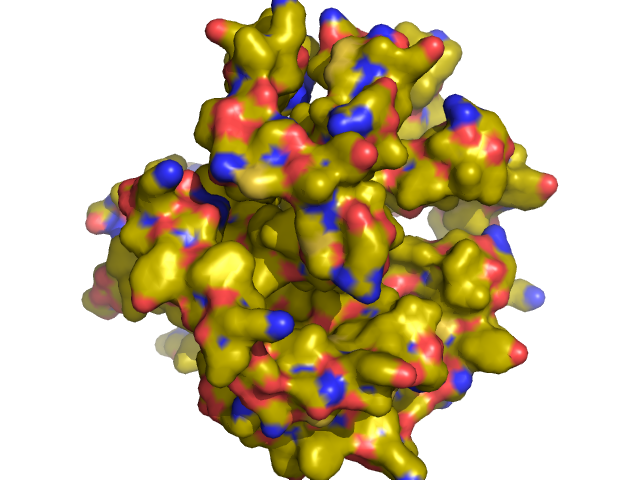

In [16]:
def visualise_interfaces(interface_dict, path_stem, protein, fpockets, extension='.pse'):
    print(f'Visualising: {protein}')
    pymol.deleteAll()
    
    # Load structure, split chains and display as surface
    pymol.do(f'load {os.getcwd()}/structures/{path_stem}{protein}' + '.pdb')
    pymol.do('split_chains')
    pymol.show_as('surface')
    
    script_text = ['split_chains\n']
    
    # Retrieve interface dataframes from dictionary
    interface_residues = interface_dict[protein]      
    
    # Identify chains to iterate selections over
    chains = set([r[0] for r in interface_residues[2]])
    
    for chain in chains:
        # Select interface residues for chains and color them red
        s = interface_residues.loc[interface_residues[2].str.startswith(chain)]
        
        # Split selection queries up so PyMol can handle them if they are too long
        num_queries = int(len(s)/70)
        selection_query =  f'select interface_{chain}, protein_{chain} and resi {s[3][0:70].astype(int).astype(str).str.cat(sep="+")}\n'
        script_text.append(selection_query)
        pymol.do(selection_query)
        # Iterate over queries
        for i in range(num_queries):
            selection_query = f'select interface_{chain}, interface_{chain} or resi {s[3][70*(i+1)+1:70*(i+1)+1+70].astype(int).astype(str).str.cat(sep="+")}\n'
            script_text.append(selection_query)
            pymol.do(selection_query)
        
    script_text.append('delete points_1\n')
    script_text.append('deselect\n')
    script_text.append('orient\n')
    
    # Add P2Rank Pocket Predictions
    ## Read In P2Rank Pocket script
    pocket_file = open(f'{os.getcwd()}/p2rank_pockets/{path_stem}/visualizations/{protein}.pdb.pml', "r")
    
    ## Read P2Rank pocket file & append interfaces
    out_script  = pocket_file.readlines()#.append(script_text)
    
    # Read in fPocket Pockets
    available_pockets = fpockets.loc[fpockets['protein'] == protein]
    protein_pockets = available_pockets['pocket_number']
    pocket_numbers = list(protein_pockets.astype(str))
    
    for pocket in pocket_numbers:
        color = float(available_pockets.loc[available_pockets['pocket_number']==float(pocket)]['Druggability Score'])       
        pocket = 'pocket'+pocket+'_vert'
        pocket_path = os.getcwd() + '/pockets/' + path_stem + protein + '_out/pockets/' + pocket + '.pqr'
        script_text.append(f'load {pocket_path}, fpocket_{pocket} partial=1\n')
        script_text.append(f'show_as spheres, (fpocket_{pocket})\n')
        script_text.append(f'color red, (fpocket_{pocket})\n')
        
    # Create and write outfile
    with open(f'{os.getcwd()}/pymol_files/integrated_interfaces_pockets/{path_stem}{protein}.pml', "w+") as f:
        f.writelines(out_script + script_text)
        f.close()
    pocket_file.close()
    
# Test function works        
visualise_interfaces(interface_dict=intraviral_interfaces,
                     path_stem='korkin_lab/IntraViralComplexes/',
                     protein='wE_homopentamer-5X29',
                     extension='.pse', fpockets=fpockets)
pymol.display()

In [18]:
# Korkin Lab Complexes
## Intraviral Complexes
print('Running Intraviral complexes')
path_stem = 'korkin_lab/IntraViralComplexes/'
### Get structure files
files = os.listdir('structures/' + path_stem)
files = [f[:-4] for f in files if f.endswith('.pdb')]

### Get fpocket files
fpockets = pd.read_csv('pockets/korkin_intraviral_druggable.csv')
proteins = fpockets['protein'].unique()

[visualise_interfaces(interface_dict=intraviral_interfaces,
                      path_stem=path_stem,
                      protein=f,
                      extension='.pse',
                      fpockets=fpockets) for f in files]

## ViralHuman Complexes
print('Running Viral Human Complexes')
path_stem = 'korkin_lab/ViralHumanComplexes/'

### Get Structure files
files = os.listdir('structures/' + path_stem)
files = [f[:-4] for f in files if f.endswith('.pdb')]

### Get pocket giles
fpockets = pd.read_csv('pockets/korkin_viral_human_druggable.csv')
proteins = fpockets['protein'].unique()

[visualise_interfaces(interface_dict=viral_human_interfaces,
                      path_stem=path_stem,
                      protein=f,
                      extension='.pse',
                      fpockets=fpockets) for f in files]

Running Intraviral complexes
Visualising: wN-Nterminal_domain_homopentamer-4UD1
Visualising: wS_homotrimer-Conf2-5X5B
Visualising: wNsp3-domain2_homotetramer-2acf
Visualising: wNsp3-domain3_homotetramer-2wct
Visualising: wNsp4_homodimer-3vc8
Visualising: wE_homopentamer-5X29
Visualising: wS_homotrimer-Conf1-5X58
Visualising: wN-Cterminal_domain_homodimer-2JW8
Visualising: wS_homotrimer-Conf1-6CS0
Visualising: wNsp7-wNsp8-wNsp12_heterotetramer-6nur
Visualising: wNsp9_tetramer-3ee7
Visualising: wNsp5_homodimer-2gt7
Visualising: wNsp10_dodecamer-2g9t
Visualising: wNsp13_homodimer-6jyt
Visualising: wNsp10-wNsp14_heterodimer-5c8u
Visualising: wS_homotrimer-Conf2-6CS1
Visualising: wS_homotrimer_treated-Conf1-6ACC
Visualising: wS_homotrimer_treated-Conf2-6ACD
Visualising: wNsp10-wNsp16_heterodimer-2xyq
Running Viral Human Complexes
Visualising: wS_trimer-ACE2-Conf1-6ACG
Visualising: wS_trimer-ACE2-Conf2-6ACJ
Visualising: wS_trimer-IGHV3-30-3-Conf1-6NB6
Visualising: wS_trimer-IGHV3-30-3-Conf2-

[None, None, None, None, None, None, None, None]